# Compare group knockoffs

This repeats the **block covariance** simulation in Fig 1 of [Dai and Barber](https://proceedings.mlr.press/v48/daia16.html).  

+ target FDR = 10%
+ $k = 50$ causal variables
+ We generate equi, SDP, MVR, and ME group knockoffs, using true covariance
+ 5 variables form a group

In [10]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using DataFrames, CSV
using DelimitedFiles
using GLM
using ProgressMeter

function TP(correct_groups, signif_groups)
    return length(signif_groups ∩ correct_groups) / max(1, length(correct_groups))
end
function FDR(correct_groups, signif_groups)
    FP = length(signif_groups) - length(signif_groups ∩ correct_groups) # number of false positives
    return FP / max(1, length(signif_groups))
end
function get_signif_groups(β, groups)
    correct_groups = Int[]
    for i in findall(!iszero, β)
        g = groups[i]
        g ∈ correct_groups || push!(correct_groups, g)
    end
    return correct_groups
end

# provides extra arguments for controlling CCD/PCA convergence criteria
function get_extra_args(method)
#     tol = occursin("sdp", string(method)) ? 0.00001 : 0.0001
    tol = 0.0001
    niter = 100
    inner_pca_iter = 1
    inner_ccd_iter = 1
    outer_iter = round(Int, niter / (inner_pca_iter + inner_ccd_iter))
    if method ∈ [:maxent, :mvr]
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif method == :sdp # sdp converges slower, so I use more stringent convergence 
        return (outer_iter=outer_iter, inner_pca_iter=inner_pca_iter, 
            inner_ccd_iter=inner_ccd_iter, tol=tol)
    elseif occursin("block", string(method)) # block update
        return (tol=tol, niter=niter)
    else
        return ()
    end
end
function simulate_data(n::Int, p::Int, G::Int, 
    pi::Int, k::Int, γ::Float64, ρ::Float64, num_v::Int, w::Float64
    ) # pi is group size, G is number of groups, w is factor that purturbs covariance matrix
    groups_true = repeat(1:Int(p/pi), inner=pi)
    Σ = simulate_block_covariance(groups_true, ρ, γ, num_v=num_v, w=w)
    
    # make eigenvalue of Σ small by doing rank 1 update
#     evals, evecs = eigen(Σ)
#     vmin, vmax = evecs[:, 1], evecs[:, end]
#     Σ = Symmetric(Σ - (evals[1]-1e-8)*vmin*vmin')

    μ = zeros(p)
    X = rand(MvNormal(μ, Σ), n)' |> Matrix
    zscore!(X, mean(X, dims=1), std(X, dims=1))
    β = zeros(p)
    β[1:k] .= rand(Normal(0, 1.0), k)
    shuffle!(β)
    y = X * β + randn(n)
    
    # define group
    groups = hc_partition_groups(X)
    correct_groups = groups[findall(!iszero, β)] |> unique
    return X, y, β, Σ, μ, groups, correct_groups
end
function run_group_knockoffs(seed; n=500, k=50, ρ=0.5, γ=0.5, verbose=false)
    Random.seed!(seed)
    p = 1000
    pi = 5  # true group sizes
    G = 200 # number of groups
    m = 5 # number of knockoffs per feature
    w = 0.0 # factor to purturb the block covariance structure
    fdr_target = 0.1
    num_v = 0 # number of v to purturb Σ, i.e. Σ = Σ + vv'
    knockoff_methods = [:equi, :maxent, :mvr, :sdp]
#     knockoff_methods = [:equi, :maxent]

    # simulate data
    X, y, β, Σ, μ, groups, correct_groups = simulate_data(n, p, G, pi, k, γ, ρ, num_v, w)

    df = DataFrame(method = Symbol[], power=Float64[], fdr=Float64[], time=Float64[], ssum=Float64[], obj=Float64[])
    for method in knockoff_methods
        # generate group knockoff
        extra_args = get_extra_args(method)
        Random.seed!(seed)
        my_t = @elapsed ko = modelX_gaussian_group_knockoffs(
            X, method, groups, μ, Σ,
            m=m, verbose=verbose; extra_args...
        )

        # feature statistic
        ko_filter = fit_lasso(y, ko, fdrs=[fdr_target])
        my_ssum = sum(abs.(ko.S))
        my_obj = ko.obj
        constraint = eigmin(Symmetric((m+1)/m*Σ - ko.S))
        if constraint < -0.0001
            error("min eval of (m+1)/m*Σ - S) is less than -0.0001")
        end

        # save output
        discovered_groups = ko_filter.selected[1]
        my_power = round(TP(correct_groups, discovered_groups), digits=3)
        my_fdr = round(FDR(correct_groups, discovered_groups), digits=3)
        println("sim $seed $method: power = $(my_power), fdr = $(my_fdr), time = $(my_t), ssum = $(my_ssum), obj=$(my_obj)")
        push!(df, [method, my_power, my_fdr, my_t, my_ssum, my_obj])
    end
    return df
end
function vary_k(seed::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_k"
    γ = 0.5
    ρ = 0.75
    verbose=true
    @showprogress for k in 10:5:50
        simdir = joinpath(dir, "k_$k")
        isdir(simdir) || mkpath(simdir)
        df = run_group_knockoffs(seed, k=k, ρ=ρ, γ=γ, verbose=verbose)
        CSV.write(joinpath(simdir, "sim$seed.csv"), df)
    end
end
function vary_gamma(seed::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_gamma"
    k = 50
    ρ = 0.75
    verbose=true
    @showprogress for gamma in 0.0:0.1:1.0
        simdir = joinpath(dir, "gamma_$gamma")
        isdir(simdir) || mkpath(simdir)
        df = run_group_knockoffs(seed, k=k, ρ=ρ, γ=gamma, verbose=verbose)
        CSV.write(joinpath(simdir, "sim$seed.csv"), df)
    end
end
function vary_rho(seed::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_rho"
    k = 50
    γ = 0.5
    verbose=true
    @showprogress for rho in 0:0.1:0.9
        simdir = joinpath(dir, "rho_$rho")
        isdir(simdir) || mkpath(simdir)
        df = run_group_knockoffs(seed, k=k, ρ=rho, γ=γ, verbose=verbose)
        CSV.write(joinpath(simdir, "sim$seed.csv"), df)
    end
end
function vary_n(seed::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_n"
    k = 50
    γ = 0.25
    ρ = 0.75
    verbose=true
    @showprogress for n in 250:250:1000
        simdir = joinpath(dir, "n$n")
        isdir(simdir) || mkpath(simdir)
        df = run_group_knockoffs(seed, n=n, k=k, ρ=ρ, γ=γ, verbose=verbose)
        CSV.write(joinpath(simdir, "sim$seed.csv"), df)
    end
end
function run_one_simulation(seed::Int)
#     vary_k(seed)
#     vary_gamma(seed)
#     vary_rho(seed)
    vary_n(seed)
end

# seed = 1111
seed = parse(Int, ARGS[1])
run_one_simulation(seed)
println("finished.")


sim 1111 equi: power = 0.391, fdr = 0.053, time = 5.091297085, ssum = 2099.999999999679, obj=900.0000000003188
Maxent initial obj = -8226.391910850396
Iter 1 (PCA): obj = -4258.250525662906, δ = 0.3499999916244681, t1 = 3.86, t2 = 2.16
Iter 2 (CCD): obj = -4258.24983181033, δ = 0.00012006441767638796, t1 = 6.1, t2 = 5.01, t3 = 0.02
Iter 3 (PCA): obj = -4258.24851139654, δ = 0.0010940382205862755, t1 = 9.95, t2 = 7.28
Iter 4 (CCD): obj = -4258.24851139654, δ = 0.0, t1 = 9.95, t2 = 9.33, t3 = 0.03
sim 1111 maxent: power = 0.326, fdr = 0.0, time = 24.665749059, ssum = 1751.4601160505997, obj=-4258.24851139654
MVR initial obj = 121119.49912004496
Iter 1 (PCA): obj = 51425.72057534104, δ = 0.7036532667268488, t1 = 3.4, t2 = 4.56
Iter 2 (CCD): obj = 51425.72057505608, δ = 2.6710541998040677e-6, t1 = 3.98, t2 = 11.5,t3 = 0.03
Iter 3 (PCA): obj = 51425.713861307566, δ = 0.002909110361053377, t1 = 8.09, t2 = 16.12
Iter 4 (CCD): obj = 51425.713861307566, δ = 4.610260871636057e-9, t1 = 8.57, t2 =

Progress:  50%|████████████████████▌                    |  ETA: 0:02:56

sim 1111 sdp: power = 0.844, fdr = 0.116, time = 9.207418474, ssum = 2099.9735137550565, obj=900.0264862449078
sim 1111 equi: power = 0.884, fdr = 0.026, time = 4.80785158, ssum = 2099.999999999679, obj=900.0000000003188
Maxent initial obj = -8226.391910850396
Iter 1 (PCA): obj = -4258.250525662906, δ = 0.3499999916244681, t1 = 4.01, t2 = 2.2
Iter 2 (CCD): obj = -4258.24983181033, δ = 0.00012006441767638796, t1 = 6.52, t2 = 5.11, t3 = 0.02
Iter 3 (PCA): obj = -4258.24851139654, δ = 0.0010940382205862755, t1 = 10.48, t2 = 7.37
Iter 4 (CCD): obj = -4258.24851139654, δ = 0.0, t1 = 10.48, t2 = 9.86, t3 = 0.04
sim 1111 maxent: power = 0.884, fdr = 0.05, time = 25.396121788, ssum = 1751.4601160505997, obj=-4258.24851139654
MVR initial obj = 121119.49912004496
Iter 1 (PCA): obj = 51425.72057534104, δ = 0.7036532667268488, t1 = 1.71, t2 = 2.29
Iter 2 (CCD): obj = 51425.72057505608, δ = 2.6710541998040677e-6, t1 = 2.0, t2 = 5.71,t3 = 0.01
Iter 3 (PCA): obj = 51425.713861307566, δ = 0.0029091103

Progress:  75%|██████████████████████████████▊          |  ETA: 0:01:38

sim 1111 sdp: power = 0.86, fdr = 0.026, time = 17.928076704, ssum = 2099.9735137550565, obj=900.0264862449078
sim 1111 equi: power = 1.0, fdr = 0.043, time = 5.011448402, ssum = 2099.999999999679, obj=900.0000000003188
Maxent initial obj = -8226.391910850396
Iter 1 (PCA): obj = -4258.250525662906, δ = 0.3499999916244681, t1 = 3.67, t2 = 2.22
Iter 2 (CCD): obj = -4258.24983181033, δ = 0.00012006441767638796, t1 = 6.16, t2 = 5.89, t3 = 0.01
Iter 3 (PCA): obj = -4258.24851139654, δ = 0.0010940382205862755, t1 = 9.88, t2 = 8.32
Iter 4 (CCD): obj = -4258.24851139654, δ = 0.0, t1 = 9.88, t2 = 11.45, t3 = 0.01
sim 1111 maxent: power = 1.0, fdr = 0.082, time = 26.412618976, ssum = 1751.4601160505997, obj=-4258.24851139654
MVR initial obj = 121119.49912004496
Iter 1 (PCA): obj = 51425.72057534104, δ = 0.7036532667268488, t1 = 3.11, t2 = 5.11
Iter 2 (CCD): obj = 51425.72057505608, δ = 2.6710541998040677e-6, t1 = 3.7, t2 = 12.02,t3 = 0.03
Iter 3 (PCA): obj = 51425.713861307566, δ = 0.00290911036

Progress: 100%|█████████████████████████████████████████| Time: 0:07:28


sim 1111 sdp: power = 1.0, fdr = 0.135, time = 17.254392883, ssum = 2099.9735137550565, obj=900.0264862449078
finished.


In [1]:
function run_repeats()
    script_dir = "/home/groups/sabatti/group_knockoff_simulations"
    for seed in 1:100
        # create .sh file to submit jobs
        filename = joinpath(script_dir, "submit.sh")
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=block$seed")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=24G")
            println(io, "#SBATCH --partition=normal,candes,owners,zihuai")
            println(io, "#SBATCH --output=/home/groups/sabatti/group_knockoff_simulations/block_cov/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(script_dir)/run_block_cov.jl $seed'")
            println(io, "julia $(script_dir)/run_block_cov.jl $seed")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim $seed")
        rm(filename, force=true)
    end
end
run_repeats()

Submitted batch job 21396577
submitted sim 1
Submitted batch job 21396578
submitted sim 2
Submitted batch job 21396579
submitted sim 3
Submitted batch job 21396580
submitted sim 4
Submitted batch job 21396581
submitted sim 5
Submitted batch job 21396582
submitted sim 6
Submitted batch job 21396583
submitted sim 7
Submitted batch job 21396584
submitted sim 8
Submitted batch job 21396585
submitted sim 9
Submitted batch job 21396586
submitted sim 10
Submitted batch job 21396587
submitted sim 11
Submitted batch job 21396588
submitted sim 12
Submitted batch job 21396589
submitted sim 13
Submitted batch job 21396590
submitted sim 14
Submitted batch job 21396591
submitted sim 15
Submitted batch job 21396592
submitted sim 16
Submitted batch job 21396593
submitted sim 17
Submitted batch job 21396594
submitted sim 18
Submitted batch job 21396596
submitted sim 19
Submitted batch job 21396597
submitted sim 20
Submitted batch job 21396598
submitted sim 21
Submitted batch job 21396599
submitted sim 

# Vary n

n 250 has 100 success
n 500 has 100 success
n 750 has 100 success
n 1000 has 100 success


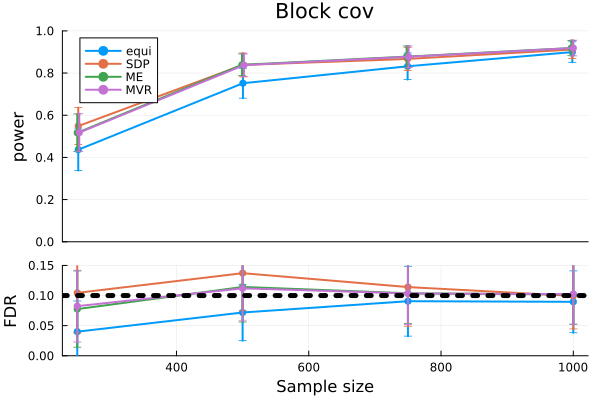

In [5]:
# load packages
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

function summarize_block_cov_vary_n(n::Int)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_n"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for seed in 1:100
        try
            result = CSV.read(joinpath(dir, "n$(n)", "sim$seed.csv"), DataFrame)
            push!(equi_powers, result[1, "power"]); push!(equi_fdrs, result[1, "fdr"])
            push!(maxent_powers, result[2, "power"]); push!(maxent_fdrs, result[2, "fdr"])
            push!(mvr_powers, result[3, "power"]); push!(mvr_fdrs, result[3, "fdr"])
            push!(sdp_powers, result[4, "power"]); push!(sdp_fdrs, result[4, "fdr"])
        catch
            continue
        end
    end
    println("n $n has $(length(equi_powers)) success")
    # save power/FDR result
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function block_cov_vary_n_plot(;ns = 250:250:1000)
    equi_powers_mean, equi_fdrs_mean, equi_powers_std, equi_fdrs_std = [], [], [], []
    sdp_powers_mean, sdp_fdrs_mean, sdp_powers_std, sdp_fdrs_std = [], [], [], []
    maxent_powers_mean, maxent_fdrs_mean, maxent_powers_std, maxent_fdrs_std = [], [], [], []
    mvr_powers_mean, mvr_fdrs_mean, mvr_powers_std, mvr_fdrs_std = [], [], [], []
    
    # summarize results
    for n in ns
        equi_powers, maxent_powers, mvr_powers, sdp_powers, 
            equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
            summarize_block_cov_vary_n(n)
        push!(equi_powers_mean, mean(equi_powers)); push!(equi_powers_std, std(equi_powers))
        push!(equi_fdrs_mean, mean(equi_fdrs)); push!(equi_fdrs_std, std(equi_fdrs))
        push!(sdp_powers_mean, mean(sdp_powers)); push!(sdp_powers_std, std(sdp_powers))
        push!(sdp_fdrs_mean, mean(sdp_fdrs)); push!(sdp_fdrs_std, std(sdp_fdrs))
        push!(maxent_powers_mean, mean(maxent_powers)); push!(maxent_powers_std, std(maxent_powers))
        push!(maxent_fdrs_mean, mean(maxent_fdrs)); push!(maxent_fdrs_std, std(maxent_fdrs))
        push!(mvr_powers_mean, mean(mvr_powers)); push!(mvr_powers_std, std(mvr_powers))
        push!(mvr_fdrs_mean, mean(mvr_fdrs)); push!(mvr_fdrs_std, std(mvr_fdrs))
    end
    
    # power plot
    title = "Block cov"
    power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
    plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

    # FDR plots
    fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
    plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = block_cov_vary_n_plot()
plot(power_plt, fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))


# Vary gamma

gamma 0.0 has 100 success
gamma 0.1 has 100 success
gamma 0.2 has 100 success
gamma 0.3 has 100 success
gamma 0.4 has 100 success
gamma 0.5 has 100 success
gamma 0.6 has 100 success
gamma 0.7 has 100 success
gamma 0.8 has 100 success
gamma 0.9 has 100 success
gamma 1.0 has 100 success


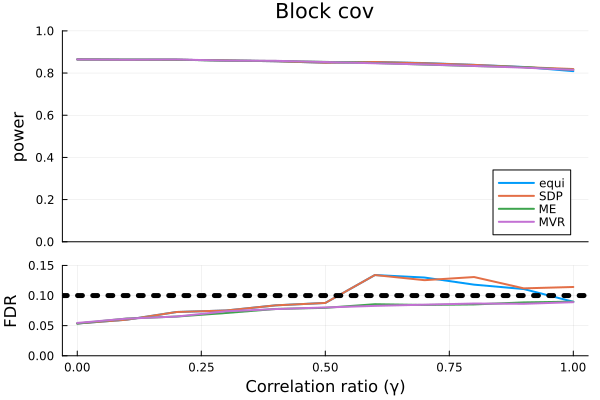

In [7]:
# load packages
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
gr(fmt=:png);

function summarize_vary_gamma(;gammas = 0.0:0.1:1.0)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_gamma"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for gamma in gammas
        success = 0
        # df is a single simulation with fixed gamma
        df = DataFrame(method=["equi","maxent","mvr","sdp"],
            power=zeros(4), fdr=zeros(4), time=zeros(4), ssum=zeros(4), obj=zeros(4))
        for seed in 1:100
#             try
                result = CSV.read(joinpath(dir, "gamma_$(gamma)", "sim$seed.csv"), DataFrame)
                df[:, 2:end] .+= result[:, 2:end]                
                success += 1
#             catch
#                 continue
#             end
        end
        df[:, 2:end] ./= success
        println("gamma $gamma has $success success")
#         @show df
        # save power/FDR result
        push!(equi_powers, df[1, "power"]); push!(equi_fdrs, df[1, "fdr"])
        push!(maxent_powers, df[2, "power"]); push!(maxent_fdrs, df[2, "fdr"])
        push!(mvr_powers, df[3, "power"]); push!(mvr_fdrs, df[3, "fdr"])
        push!(sdp_powers, df[4, "power"]); push!(sdp_fdrs, df[4, "fdr"])
    end
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function gamma_plot(;gammas = 0.0:0.1:1.0)
    # summarize results
    equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
        summarize_vary_gamma(gammas=gammas)
    
    # power plot
    power_plt = plot(gammas, equi_powers, xtick=false, title="Block cov",
        ylabel="power", label="equi", w=2, ylim=(0, 1.0))
    plot!(gammas, sdp_powers, label = "SDP", w=2)
    plot!(gammas, maxent_powers, label = "ME", w=2)
    plot!(gammas, mvr_powers, label = "MVR", w=2)
    
    # FDR plots
    fdr_plt = plot(gammas, equi_fdrs, xlabel="Correlation ratio (γ)",
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), legend=false)
    plot!(gammas, sdp_fdrs, label = "SDP", w=2)
    plot!(gammas, maxent_fdrs, label = "ME", w=2)
    plot!(gammas, mvr_fdrs, label = "MVR", w=2)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = gamma_plot()
plot(power_plt, fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))



## Vary Rho

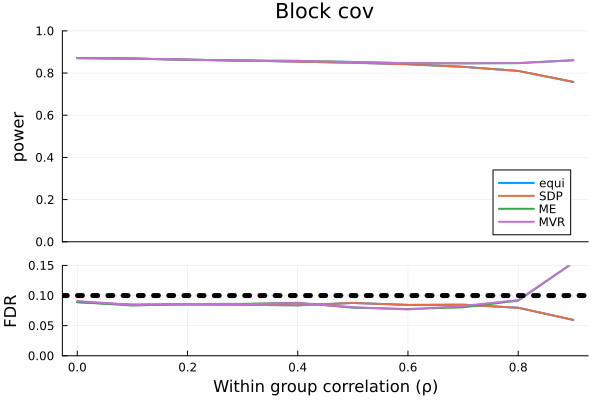

In [8]:
# load packages
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
gr(fmt=:png);

function summarize_vary_rho(;rhos = 0.0:0.1:0.9)
    dir = "/home/groups/sabatti/group_knockoff_simulations/block_cov/vary_rho"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for rho in rhos
        success = 0
        # df is a single simulation with fixed gamma
        df = DataFrame(method=["equi","maxent","mvr","sdp"],
            power=zeros(4), fdr=zeros(4), time=zeros(4), ssum=zeros(4), obj=zeros(4))
        for seed in 1:100
            try
                result = CSV.read(joinpath(dir, "rho_$(rho)", "sim$seed.csv"), DataFrame)
                df[:, 2:end] .+= result[:, 2:end]                
                success += 1
            catch
                continue
            end
        end
        df[:, 2:end] ./= success
#         println("rho $rho has $success success")
#         @show df
        # save power/FDR result
        push!(equi_powers, df[1, "power"]); push!(equi_fdrs, df[1, "fdr"])
        push!(maxent_powers, df[2, "power"]); push!(maxent_fdrs, df[2, "fdr"])
        push!(mvr_powers, df[3, "power"]); push!(mvr_fdrs, df[3, "fdr"])
        push!(sdp_powers, df[4, "power"]); push!(sdp_fdrs, df[4, "fdr"])
    end
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function rho_plot(;rhos = 0.0:0.1:0.9)
    # summarize results
    equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
        summarize_vary_rho(rhos=rhos)
    
    # power plot
    power_plt = plot(rhos, equi_powers, xtick=false, 
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title="Block cov")
    plot!(rhos, sdp_powers, label = "SDP", w=2)
    plot!(rhos, maxent_powers, label = "ME", w=2)
    plot!(rhos, mvr_powers, label = "MVR", w=2)
    
    # FDR plots
    fdr_plt = plot(rhos, equi_fdrs, xlabel="Within group correlation (ρ)", 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), legend=false)
    plot!(rhos, sdp_fdrs, label = "SDP", w=2)
    plot!(rhos, maxent_fdrs, label = "ME", w=2)
    plot!(rhos, mvr_fdrs, label = "MVR", w=2)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = rho_plot()
plot(power_plt, fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

## Vary Gamma (old)

These uses 2nd order knockoff where covariance is sample covariances 

gamma 0.0 has 100 success
df = 4×6 DataFrame
 Row │ method  power    fdr      time         ssum      obj
     │ String  Float64  Float64  Float64      Float64   Float64
─────┼───────────────────────────────────────────────────────────
   1 │ equi    0.87836  0.14859     0.350531  1484.29    180.175
   2 │ maxent  0.87883  0.17741    12.6264    1069.21   -313.213
   3 │ mvr     0.87883  0.17666    14.9282     946.712  2545.54
   4 │ sdp     0.8742   0.14237  2156.98      1522.23    137.169
gamma 0.1 has 100 success
df = 4×6 DataFrame
 Row │ method  power    fdr      time         ssum     obj
     │ String  Float64  Float64  Float64      Float64  Float64
─────┼──────────────────────────────────────────────────────────
   1 │ equi    0.87183  0.1769      0.346541  902.523   1361.54
   2 │ maxent  0.87063  0.18929    12.574     690.283  -1080.05
   3 │ mvr     0.87007  0.18972    14.9345    559.742   4292.0
   4 │ sdp     0.87068  0.16752  2077.93      939.996   1323.78
gamma 0.2 has 100 s

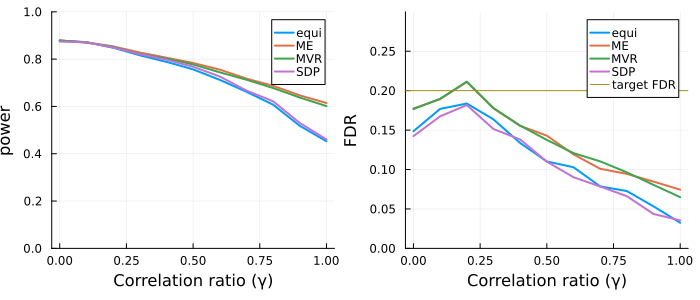

In [5]:
# load packages
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
gr(fmt=:png);

function summarize_vary_gamma(;gammas = 0.0:0.1:1.0)
    dir = "/scratch/users/bbchu/group_knockoff_simulations/block_cov/vary_gamma"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for gamma in gammas
        success = 0
        # df is a single simulation with fixed gamma
        df = DataFrame(method=["equi","maxent","mvr","sdp"],
            power=zeros(4), fdr=zeros(4), time=zeros(4), ssum=zeros(4), obj=zeros(4))
        for seed in 1:100
            try
                result = CSV.read(joinpath(dir, "gamma_$(gamma)", "sim$seed"), DataFrame)
                df[:, 2:end] .+= result[:, 2:end]                
                success += 1
            catch
                continue
            end
        end
        df[:, 2:end] ./= success
        println("gamma $gamma has $success success")
        @show df
        # save power/FDR result
        push!(equi_powers, df[1, "power"]); push!(equi_fdrs, df[1, "fdr"])
        push!(maxent_powers, df[2, "power"]); push!(maxent_fdrs, df[2, "fdr"])
        push!(mvr_powers, df[3, "power"]); push!(mvr_fdrs, df[3, "fdr"])
        push!(sdp_powers, df[4, "power"]); push!(sdp_fdrs, df[4, "fdr"])
    end
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function gamma_plot(;gammas = 0.0:0.1:1.0)
    # summarize results
    equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
        summarize_vary_gamma(gammas=gammas)
    
    # power plot
    power_plt = plot(gammas, equi_powers, xlabel="Correlation ratio (γ)", 
        ylabel="power", label="equi", w=2, ylim=(0, 1.0))
    plot!(gammas, maxent_powers, label = "ME", w=2)
    plot!(gammas, mvr_powers, label = "MVR", w=2)
    plot!(gammas, sdp_powers, label = "SDP", w=2)
    
    # FDR plots
    fdr_plt = plot(gammas, equi_fdrs, xlabel="Correlation ratio (γ)", 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.3))
    plot!(gammas, maxent_fdrs, label = "ME", w=2)
    plot!(gammas, mvr_fdrs, label = "MVR", w=2)
    plot!(gammas, sdp_fdrs, label = "SDP", w=2)
    hline!(fdr_plt, [0.2], label = "target FDR")
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = gamma_plot()
plot(power_plt, fdr_plt, size=(700, 300), bottommargin=5Plots.mm)

# Vary rho (old)

rho 0.0 has 100 success
df = 4×6 DataFrame
 Row │ method  power    fdr      time       ssum     obj
     │ String  Float64  Float64  Float64    Float64  Float64
─────┼────────────────────────────────────────────────────────────
   1 │ equi    0.87921  0.17671   0.335737  998.58      0.0
   2 │ maxent  0.87921  0.17671   5.02245   998.491    -0.0785998
   3 │ mvr     0.87921  0.17671  12.603     988.467  2013.49
   4 │ sdp     0.87921  0.17671   0.39652   998.58      0.0
rho 0.1 has 100 success
df = 4×6 DataFrame
 Row │ method  power    fdr      time         ssum     obj
     │ String  Float64  Float64  Float64      Float64  Float64
─────┼──────────────────────────────────────────────────────────
   1 │ equi    0.87706  0.19671     0.332283  895.311   325.761
   2 │ maxent  0.87322  0.22415    12.6451    581.834  -789.941
   3 │ mvr     0.87274  0.223      14.9134    530.185  3586.1
   4 │ sdp     0.87239  0.19499  1270.89      912.822   308.886
rho 0.2 has 100 success
df = 4×6 DataFram

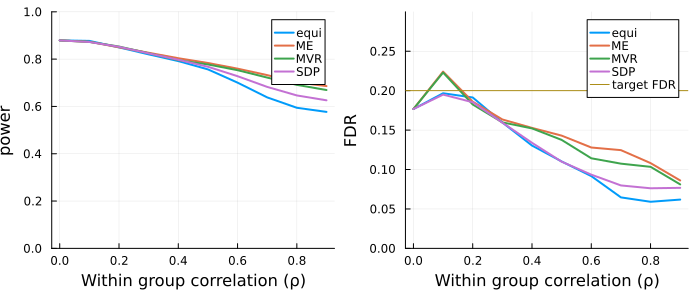

In [2]:
# load packages
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
gr(fmt=:png);

function summarize_vary_rho(;rhos = 0.0:0.1:0.9)
    dir = "/scratch/users/bbchu/group_knockoff_simulations/block_cov/vary_rho"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for rho in rhos
        success = 0
        # df is a single simulation with fixed gamma
        df = DataFrame(method=["equi","maxent","mvr","sdp"],
            power=zeros(4), fdr=zeros(4), time=zeros(4), ssum=zeros(4), obj=zeros(4))
        for seed in 1:100
            try
                result = CSV.read(joinpath(dir, "rho_$(rho)", "sim$seed"), DataFrame)
                df[:, 2:end] .+= result[:, 2:end]                
                success += 1
            catch
                continue
            end
        end
        df[:, 2:end] ./= success
        println("rho $rho has $success success")
        @show df
        # save power/FDR result
        push!(equi_powers, df[1, "power"]); push!(equi_fdrs, df[1, "fdr"])
        push!(maxent_powers, df[2, "power"]); push!(maxent_fdrs, df[2, "fdr"])
        push!(mvr_powers, df[3, "power"]); push!(mvr_fdrs, df[3, "fdr"])
        push!(sdp_powers, df[4, "power"]); push!(sdp_fdrs, df[4, "fdr"])
    end
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function rho_plot(;rhos = 0.0:0.1:0.9)
    # summarize results
    equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
        summarize_vary_rho(rhos=rhos)
    
    # power plot
    power_plt = plot(rhos, equi_powers, xlabel="Within group correlation (ρ)", 
        ylabel="power", label="equi", w=2, ylim=(0, 1.0))
    plot!(rhos, maxent_powers, label = "ME", w=2)
    plot!(rhos, mvr_powers, label = "MVR", w=2)
    plot!(rhos, sdp_powers, label = "SDP", w=2)
    
    # FDR plots
    fdr_plt = plot(rhos, equi_fdrs, xlabel="Within group correlation (ρ)", 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.3))
    plot!(rhos, maxent_fdrs, label = "ME", w=2)
    plot!(rhos, mvr_fdrs, label = "MVR", w=2)
    plot!(rhos, sdp_fdrs, label = "SDP", w=2)
    hline!(fdr_plt, [0.2], label = "target FDR")
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = rho_plot()
plot(power_plt, fdr_plt, size=(700, 300), bottommargin=5Plots.mm)

## Vary k

k 10 has 100 success
df = 4×6 DataFrame
 Row │ method  power    fdr      time      ssum     obj
     │ String  Float64  Float64  Float64   Float64  Float64
─────┼───────────────────────────────────────────────────────
   1 │ equi    0.74646  0.10732   29.3382  85.4965   2845.17
   2 │ maxent  0.75679  0.12823   13.9611  61.0775  -4667.47
   3 │ mvr     0.75012  0.12485   21.2544  47.6865  44442.7
   4 │ sdp     0.73679  0.10413  152.961   89.3605   2841.33
k 15 has 100 success
df = 4×6 DataFrame
 Row │ method  power    fdr      time        ssum     obj
     │ String  Float64  Float64  Float64     Float64  Float64
─────┼─────────────────────────────────────────────────────────
   1 │ equi    0.71856  0.09772    0.362909  85.4965   2845.17
   2 │ maxent  0.75873  0.14596   12.474     61.0775  -4667.47
   3 │ mvr     0.75276  0.13561   20.827     47.6865  44442.7
   4 │ sdp     0.73613  0.10812  150.768     89.3605   2841.33
k 20 has 100 success
df = 4×6 DataFrame
 Row │ method  power    

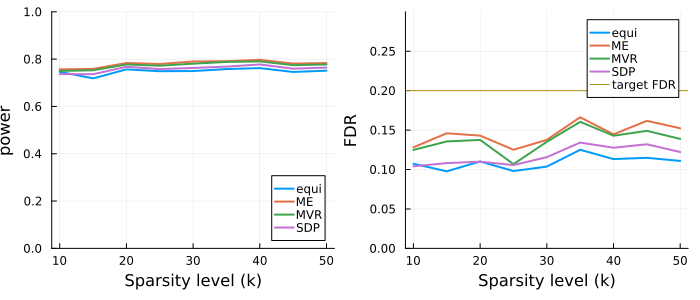

In [3]:
# load packages
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
gr(fmt=:png);

function summarize_vary_k(;ks = 10:5:50)
    dir = "/scratch/users/bbchu/group_knockoff_simulations/block_cov/vary_k"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for k in ks
        success = 0
        # df is a single simulation with fixed gamma
        df = DataFrame(method=["equi","maxent","mvr","sdp"],
            power=zeros(4), fdr=zeros(4), time=zeros(4), ssum=zeros(4), obj=zeros(4))
        for seed in 1:100
            try
                result = CSV.read(joinpath(dir, "k_$(k)", "sim$seed"), DataFrame)
                df[:, 2:end] .+= result[:, 2:end]                
                success += 1
            catch
                continue
            end
        end
        df[:, 2:end] ./= success
        println("k $k has $success success")
        @show df
        # save power/FDR result
        push!(equi_powers, df[1, "power"]); push!(equi_fdrs, df[1, "fdr"])
        push!(maxent_powers, df[2, "power"]); push!(maxent_fdrs, df[2, "fdr"])
        push!(mvr_powers, df[3, "power"]); push!(mvr_fdrs, df[3, "fdr"])
        push!(sdp_powers, df[4, "power"]); push!(sdp_fdrs, df[4, "fdr"])
    end
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function k_plot(;ks = 10:5:50)
    # summarize results
    equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
        summarize_vary_k(ks=ks)
    
    # power plot
    power_plt = plot(ks, equi_powers, xlabel="Sparsity level (k)", 
        ylabel="power", label="equi", w=2, ylim=(0, 1.0))
    plot!(ks, maxent_powers, label = "ME", w=2)
    plot!(ks, mvr_powers, label = "MVR", w=2)
    plot!(ks, sdp_powers, label = "SDP", w=2)
    
    # FDR plots
    fdr_plt = plot(ks, equi_fdrs, xlabel="Sparsity level (k)", 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.3))
    plot!(ks, maxent_fdrs, label = "ME", w=2)
    plot!(ks, mvr_fdrs, label = "MVR", w=2)
    plot!(ks, sdp_fdrs, label = "SDP", w=2)
    hline!(fdr_plt, [0.2], label = "target FDR")
    
    return power_plt, fdr_plt
end
power_plt, fdr_plt = k_plot()
plot(power_plt, fdr_plt, size=(700, 300), bottommargin=5Plots.mm)